In [61]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Model parameters
J = 1.0
E_values = [0.5, 0.0]
T_min, T_max = 0.001, 7.0
n_steps = 1_000_000
n_equilibrate = 100_000

# Base grid
n_temps = 50
base_T = np.linspace(T_min, T_max, n_temps)

# 10 extra points in (0.2, 0.5), excluding endpoints to avoid duplicates
extra_T = np.linspace(0.2, 0.5, 12)[1:-1]  # -> 10 interior points

# Merge, unique, and sort
temperatures = np.union1d(base_T, extra_T)

# Keep n_temps consistent with the new grid length
n_temps = temperatures.size

# Corner directions (angles in radians and degrees)
corner_angles = {
    1: 3*np.pi/4,    # 135° - Northwest ↖
    2: np.pi/4,      # 45°  - Northeast ↗  
    3: 5*np.pi/4,    # 225° - Southwest ↙
    4: 7*np.pi/4     # 315° - Southeast ↘
}

# Unit vectors for each corner direction
corner_vectors = {}
for corner, angle in corner_angles.items():
    corner_vectors[corner] = np.array([np.cos(angle), np.sin(angle)])

def calculate_site_energy(spins, i, j, J, E):
    """Calculate energy contribution of site (i,j) based on its spin corner state"""
    L = spins.shape[0]
    corner_i = spins[i, j]
    spin_vector_i = corner_vectors[corner_i]
    
    # Get neighboring corner states (with periodic boundary conditions)
    neighbors = [
        spins[(i-1) % L, j],  # up
        spins[(i+1) % L, j],  # down  
        spins[i, (j-1) % L],  # left
        spins[i, (j+1) % L]   # right
    ]
    
    # Calculate interaction energy with all neighbors
    interaction_energy = 0.0
    for neighbor_corner in neighbors:
        spin_vector_j = corner_vectors[neighbor_corner]
        dot_product = np.dot(spin_vector_i, spin_vector_j)
        interaction_energy += -J * dot_product
    
    # Apply 1/2 factor to interaction term
    interaction_energy *= 0.5
    
    # External field energy (if E != 0)
    field_energy = 0.0
    if E != 0:
        y_field = np.array([0, 1])
        field_energy = -E * np.dot(spin_vector_i, y_field)
    
    total_energy = interaction_energy + field_energy
    return total_energy

def metropolis_step(spins, beta, J, E):
    """Perform one Monte Carlo step by changing a spin's corner state"""
    L = spins.shape[0]
    
    # Choose random site
    i = random.randint(0, L-1)
    j = random.randint(0, L-1)
    
    # Current corner state
    old_corner = spins[i, j]
    
    # Propose new random corner state (different from current)
    possible_corners = [1, 2, 3, 4]
    possible_corners.remove(old_corner)
    new_corner = random.choice(possible_corners)
    
    # Calculate energy change
    # Energy with old corner
    spins[i, j] = old_corner
    energy_old = calculate_site_energy(spins, i, j, J, E)
    
    # Energy with new corner
    spins[i, j] = new_corner
    energy_new = calculate_site_energy(spins, i, j, J, E)
    
    # Energy difference
    delta_E = energy_new - energy_old
    
    # Metropolis criterion
    if delta_E <= 0 or random.random() < np.exp(-beta * delta_E):
        # Accept the new corner state
        accepted = True
    else:
        # Reject - restore old corner state
        spins[i, j] = old_corner
        accepted = False
    
    return accepted, old_corner, new_corner

def run_monte_carlo(T, J, E, n_steps, n_equilibrate):
    """Run Monte Carlo simulation at temperature T with field strength E"""
    beta = 1.0 / T
    L = 2  # 2x2 system
    
    # Initialize random corner states
    spins = np.random.choice([1, 2, 3, 4], size=(L, L))
    
    # Initialize accumulators
    total_energy_sum = 0.0
    corner_energy_sums = {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
    corner_counts = {1: 0, 2: 0, 3: 0, 4: 0}
    upper_energy_sum = 0.0
    lower_energy_sum = 0.0
    upper_count = 0
    lower_count = 0
    
    # Monte Carlo steps
    accepted_moves = 0
    total_moves = 0
    
    for step in range(n_steps):
        # Perform one sweep (L^2 attempted moves)
        for _ in range(L * L):
            accepted, old_corner, new_corner = metropolis_step(spins, beta, J, E)
            total_moves += 1
            if accepted:
                accepted_moves += 1
        
        # After equilibration, collect data
        if step >= n_equilibrate:
            for i in range(L):
                for j in range(L):
                    site_energy = calculate_site_energy(spins, i, j, J, E)
                    corner = spins[i, j]
                    
                    # Update accumulators
                    total_energy_sum += site_energy
                    corner_energy_sums[corner] += site_energy
                    corner_counts[corner] += 1
                    
                    if corner in [1, 2]:  # Upper corners
                        upper_energy_sum += site_energy
                        upper_count += 1
                    else:  # Lower corners
                        lower_energy_sum += site_energy
                        lower_count += 1
    
    # Calculate number of sampling steps
    n_sampling_steps = n_steps - n_equilibrate
    n_sites = L * L
    
    # Calculate overall average energy
    Ec_avg = total_energy_sum / (n_sampling_steps * n_sites)
    
    # Calculate level averages (only meaningful when E != 0)
    E1_avg = upper_energy_sum / upper_count if upper_count > 0 else 0.0
    E2_avg = lower_energy_sum / lower_count if lower_count > 0 else 0.0
    
    # Calculate average energies for each corner
    corner_avg_energies = {}
    for corner in [1, 2, 3, 4]:
        if corner_counts[corner] > 0:
            corner_avg_energies[corner] = corner_energy_sums[corner] / corner_counts[corner]
        else:
            corner_avg_energies[corner] = 0.0
    
    # Calculate average populations per step
    corner_avg_populations = {}
    for corner in [1, 2, 3, 4]:
        corner_avg_populations[corner] = corner_counts[corner] / n_sampling_steps
    
    acceptance_rate = accepted_moves / total_moves if total_moves > 0 else 0
    
    return Ec_avg, E1_avg, E2_avg, corner_avg_energies, corner_avg_populations, acceptance_rate

# Run simulations for different E values
results = {}

for E in E_values:
    print(f"Starting simulation with E = {E}")
    
    # Arrays to store results
    Ec_results = []
    E1_results = []
    E2_results = []
    corner_energy_results = {1: [], 2: [], 3: [], 4: []}
    corner_population_results = {1: [], 2: [], 3: [], 4: []}
    acceptance_rates = []
    
    # Run simulation for each temperature
    for i, T in enumerate(temperatures):
        print(f"  T = {T:.2f} ({i+1}/{n_temps})", end="\r")
        
        # Run Monte Carlo at this temperature
        Ec_avg, E1_avg, E2_avg, corner_energies, corner_populations, acc_rate = run_monte_carlo(
            T, J, E, n_steps, n_equilibrate)
        
        # Store results
        Ec_results.append(Ec_avg)
        E1_results.append(E1_avg)
        E2_results.append(E2_avg)
        acceptance_rates.append(acc_rate)
        
        for corner in [1, 2, 3, 4]:
            corner_energy_results[corner].append(corner_energies[corner])
            corner_population_results[corner].append(corner_populations[corner])
    
    print(f"\nSimulation with E = {E} completed!")
    
    # Store results for this E value
    results[E] = {
        'Ec': np.array(Ec_results),
        'E1': np.array(E1_results),
        'E2': np.array(E2_results),
        'corner_energies': {c: np.array(corner_energy_results[c]) for c in [1,2,3,4]},
        'corner_populations': {c: np.array(corner_population_results[c]) for c in [1,2,3,4]},
        'acceptance_rates': np.array(acceptance_rates)
    }


Starting simulation with E = 0.5
  T = 7.00 (60/60)
Simulation with E = 0.5 completed!
Starting simulation with E = 0.0
  T = 7.00 (60/60)
Simulation with E = 0.0 completed!


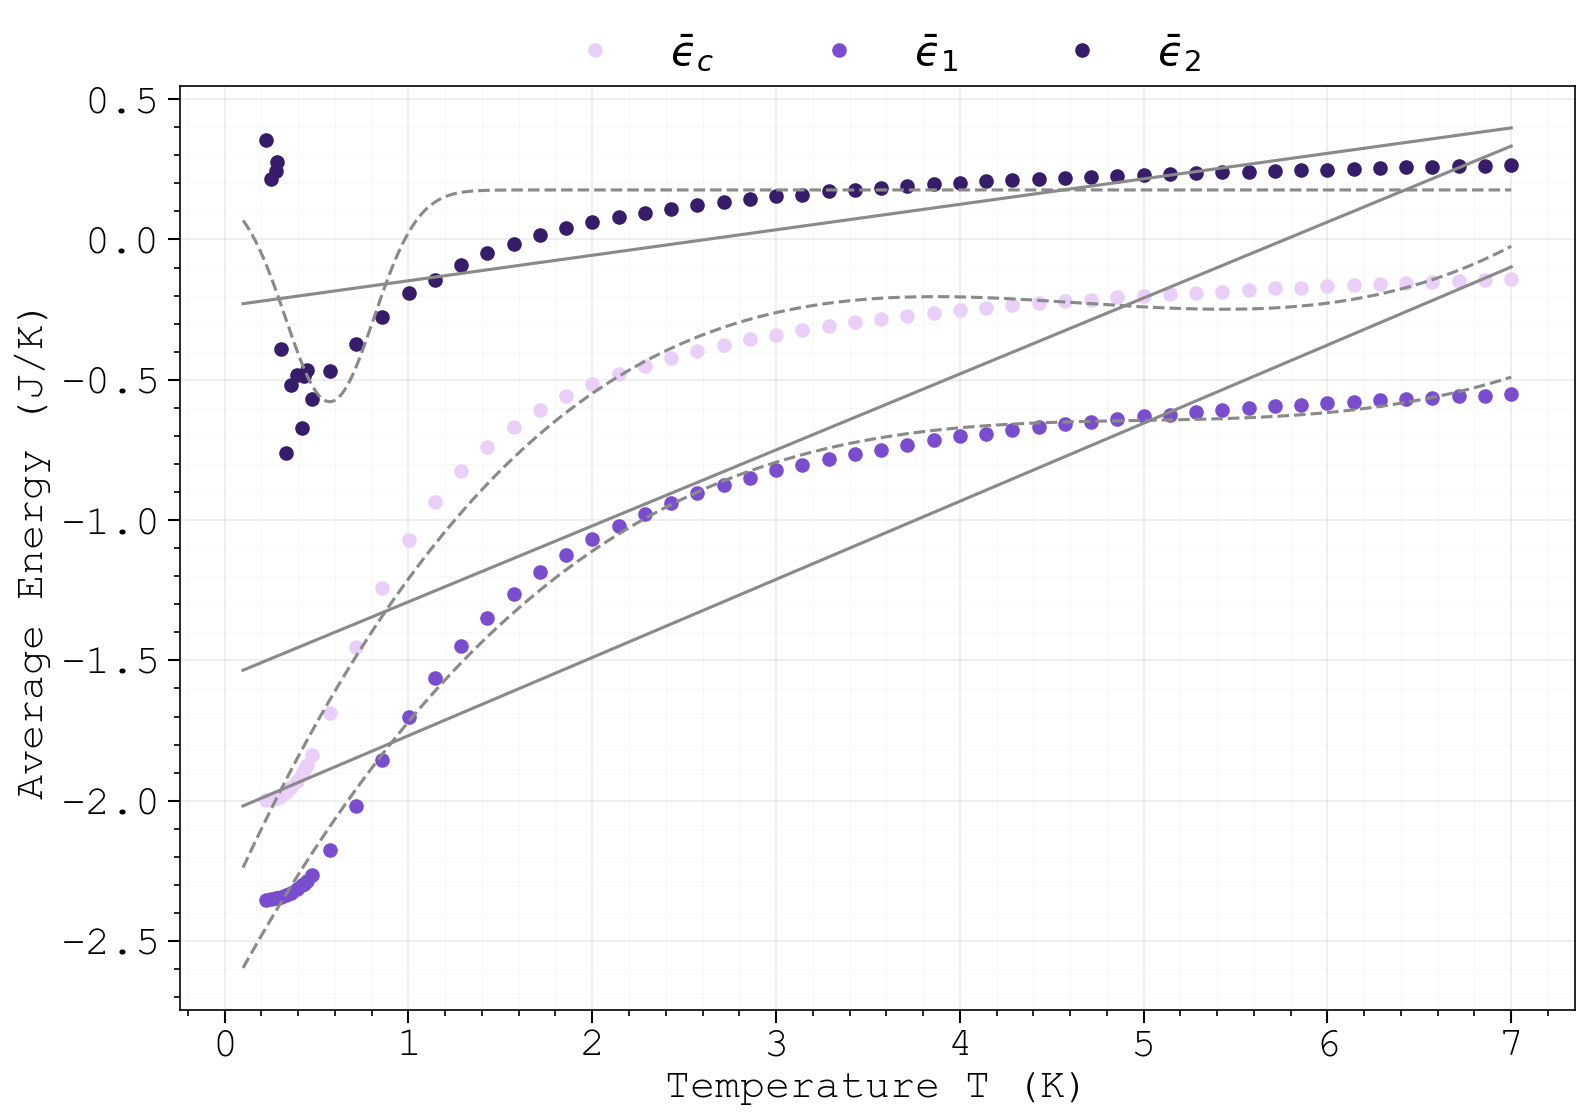

In [235]:
# Requires: `temperatures` (1D), `results` dict with keys:
# results[0.0]['Ec'], results[0.5]['E1'], results[0.5]['E2']

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# --------- Fonts & export (like his) ---------
plt.rcParams.update({
    'font.family': ['Courier New', 'DejaVu Sans Mono', 'monospace'],
    'font.size': 20,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'pdf.fonttype': 42, 'ps.fonttype': 42,
    'savefig.dpi': 300, 'figure.dpi': 150,
})

# --------- Grid & axes polish (like his) ---------
def polish_axes(ax):
    ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
    ax.minorticks_on()
    ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
    ax.set_axisbelow(True)
    for side in ("bottom", "left", "top", "right"):
        ax.spines[side].set_linewidth(0.8)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', direction='out', length=6, width=1.0)
    ax.tick_params(which='minor', length=3, width=0.8)

# ---- Gaussian-dip model for E2 dashed: y = L - C * exp(-((x - x0)^2) / a^2)
def fit_gaussian_dip(x_fit, y_fit, xs=None, n_x0=60, n_a=40):
    x = np.asarray(x_fit, float); y = np.asarray(y_fit, float)
    order = np.argsort(x); x, y = x[order], y[order]
    if xs is None:
        xs = np.linspace(x.min(), x.max(), 400)

    xr = x.max() - x.min()
    x0_grid = np.linspace(x.min(), x.max(), n_x0)
    a_grid  = np.linspace(0.05 * xr if xr > 0 else 1.0, 0.8 * xr if xr > 0 else 2.0, n_a)

    best = None
    for x0 in x0_grid:
        d2 = (x - x0) ** 2
        for a in a_grid:
            if a <= 0: 
                continue
            phi = np.exp(-d2 / (a * a))
            A = np.column_stack([np.ones_like(x), -phi])  # [L, C]
            coef, *_ = np.linalg.lstsq(A, y, rcond=None)  # L, C
            resid = A @ coef - y
            sse = float(resid.T @ resid)
            if (best is None) or (sse < best[0]):
                best = (sse, coef, x0, a)

    _, (L, C), x0_best, a_best = best
    yhat = L - C * np.exp(-((xs - x0_best) ** 2) / (a_best * a_best))
    return xs, yhat, (L, C, x0_best, a_best)

# --------- Drop first two lowest-T points (use sorted-by-T indices) ---------
T = np.asarray(temperatures, float)
order = np.argsort(T)
keep_idx = order[2:]

T_plot = T[keep_idx]
Ec  = np.asarray(results[0.0]['Ec'], float)[keep_idx]
E1  = np.asarray(results[0.5]['E1'], float)[keep_idx]
E2  = np.asarray(results[0.5]['E2'], float)[keep_idx]

# --------- Colors ---------
col_Ec = "#eacff8"
col_E1 = "#7a4dce"
col_E2 = "#371c69"
reg_color = "#8a8a8a"
lw_line   = 1.5

# --------- Plot ---------
fig, ax = plt.subplots(figsize=(12, 8))

# raw points
ax.plot(T_plot, Ec, 'o', ms=6, color=col_Ec, label=r'$\bar{ϵ}_c $')
ax.plot(T_plot, E1, 'o', ms=6, color=col_E1, label=r'$\bar{ϵ}_1 $')
ax.plot(T_plot, E2, 'o', ms=6, color=col_E2, label=r'$\bar{ϵ}_2 $')

# ----- Lines must start at T = 0.1 -----
start_x = 0.1
end_x   = max(T_plot.max(), start_x + 1e-6)  # safety
xs = np.linspace(start_x, end_x, 400)

# Ec: LR + dashed polynomial (deg=3)
m, b = np.polyfit(T_plot, Ec, 1)
ax.plot(xs, m*xs + b, color=reg_color, lw=lw_line, zorder=2)
coef_ec = np.polyfit(T_plot, Ec, 3)
ax.plot(xs, np.poly1d(coef_ec)(xs), color=reg_color, lw=lw_line, ls='--', zorder=2)

# E1: LR + dashed polynomial (deg=3)
m, b = np.polyfit(T_plot, E1, 1)
ax.plot(xs, m*xs + b, color=reg_color, lw=lw_line, zorder=2)
coef_e1 = np.polyfit(T_plot, E1, 3)
ax.plot(xs, np.poly1d(coef_e1)(xs), color=reg_color, lw=lw_line, ls='--', zorder=2)

# E2: LR + dashed Gaussian-dip fit (evaluated from T=0.1)
m, b = np.polyfit(T_plot, E2, 1)
ax.plot(xs, m*xs + b, color=reg_color, lw=lw_line, zorder=2)
xs_e2, ys_e2, _ = fit_gaussian_dip(T_plot, E2, xs=xs)  # uses your y = L - C exp(...)
ax.plot(xs_e2, ys_e2, color=reg_color, lw=lw_line, ls='--', zorder=2)

# labels with units; no title
ax.set_xlabel("Temperature T (K)")
ax.set_ylabel("Average Energy (J/K)")
polish_axes(ax)

# legend above
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.10),
          ncol=3, frameon=False)

plt.show()
# Optional saves:
fig.savefig("energy_comparison.png", dpi=300, bbox_inches="tight", pad_inches=0.01)


In [142]:
from matplotlib.lines import Line2D

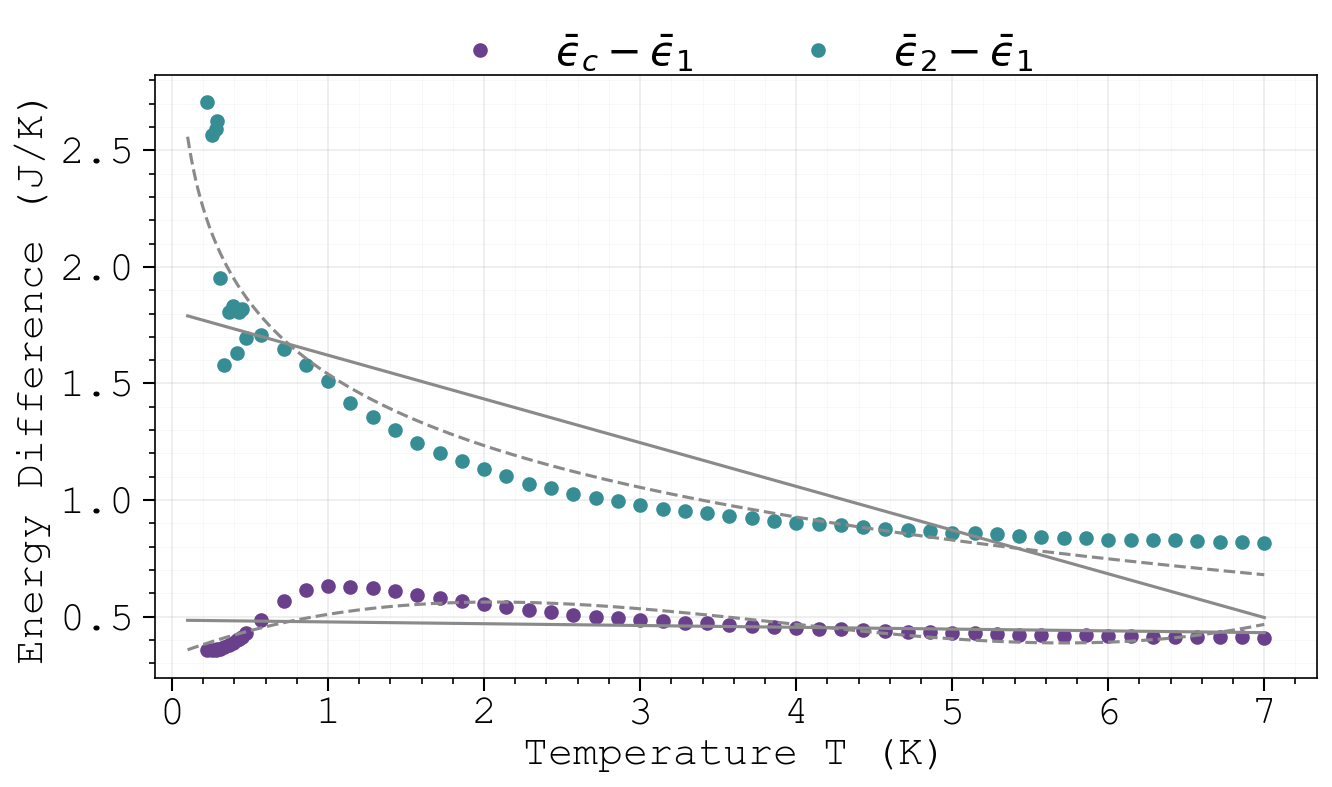

In [225]:
# ----- Second graph: dashed curve for E2−E1 uses logarithmic fit y = a + b ln(T + δ) -----
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D  # <-- needed for LR/PR legend handles

plt.rcParams.update({
    'font.family': ['Courier New', 'DejaVu Sans Mono', 'monospace'],
    'font.size': 20, 'axes.labelsize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20,
    'legend.fontsize': 20, 'pdf.fonttype': 42, 'ps.fonttype': 42,
    'savefig.dpi': 300, 'figure.dpi': 150,
})

def polish_axes(ax):
    ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
    ax.minorticks_on()
    ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
    ax.set_axisbelow(True)
    for s in ("bottom","left","top","right"):
        ax.spines[s].set_linewidth(0.8)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', direction='out', length=6, width=1.0)
    ax.tick_params(which='minor', length=3, width=0.8)

def smooth_poly(x, y, deg=2, n=400):
    x = np.asarray(x); y = np.asarray(y)
    order = np.argsort(x)
    x, y = x[order], y[order]
    deg = min(deg, max(1, len(x) - 1))
    coef = np.polyfit(x, y, deg)
    p = np.poly1d(coef)
    xs = np.linspace(x.min(), x.max(), n)
    ys = p(xs)
    return xs, ys

def log_fit_eval(x_fit, y_fit, xs=None, eps=None):
    """
    Fit y = a + b * ln(x + eps). If min(x)<=0, auto-shift by eps = -min(x)+1e-9.
    Returns xs, yhat, eps.
    """
    x_fit = np.asarray(x_fit, float); y_fit = np.asarray(y_fit, float)
    if eps is None:
        eps = 0.0 if np.min(x_fit) > 0 else (-np.min(x_fit) + 1e-9)
    X = np.log(x_fit + eps)
    a1, a0 = np.polyfit(X, y_fit, 1)   # slope, intercept
    if xs is None:
        xs = np.linspace(np.min(x_fit), np.max(x_fit), 400)
    yhat = a0 + a1 * np.log(xs + eps)
    return xs, yhat, eps

# --------- Slice from 3rd point (by T) ---------
T = np.asarray(temperatures, float)
order = np.argsort(T)
keep_idx = order[2:]

T_plot = T[keep_idx]
E1 = np.asarray(results[0.5]['E1'], float)[keep_idx]
E2 = np.asarray(results[0.5]['E2'], float)[keep_idx]
Ec = np.asarray(results[0.0]['Ec'], float)[keep_idx]

diff_E2_E1 = E2 - E1
diff_Ec_E1 = Ec - E1

# --------- Colours ---------
col_e2e1 = "#378d94"  # teal   (E2−E1)
col_ece1 = "#6a408d"  # purple (Ec−E1)
reg_color = "#8a8a8a"
lw_line   = 1.5

# --------- Plot ---------
fig, ax = plt.subplots(figsize=(10, 6))

# raw points (keep your labels exactly)
ax.plot(T_plot, diff_Ec_E1, 'o', ms=6, color=col_ece1, label=r'$\bar{ϵ}_c - \bar{ϵ}_1$')
ax.plot(T_plot, diff_E2_E1, 'o', ms=6, color=col_e2e1, label=r'$\bar{ϵ}_2 - \bar{ϵ}_1$')

ax.set_xlabel("Temperature T (K)")
ax.set_ylabel("Energy Difference (J/K)")
polish_axes(ax)

# ---- lock axes (fits won't change range)
xlim0, ylim0 = ax.get_xlim(), ax.get_ylim()

# ---- Draw all fitted lines from T = 0.1 to T = 7.0 ----
xs_draw = np.linspace(0.1, 7.0, 600)

# ---- LR (solid grey), fit on sliced data & draw on [0.1, 7]
m, b = np.polyfit(T_plot, diff_E2_E1, 1)
ax.plot(xs_draw, m*xs_draw + b, color=reg_color, lw=lw_line)

m, b = np.polyfit(T_plot, diff_Ec_E1, 1)
ax.plot(xs_draw, m*xs_draw + b, color=reg_color, lw=lw_line)

# ---- Dashed curves:
#      - E2−E1: logarithmic fit (a + b ln T) — avoid ln(0) with tiny eps
xs_ln, y_ln, _ = log_fit_eval(T_plot, diff_E2_E1, xs=xs_draw, eps=1e-9)
ax.plot(xs_ln, y_ln, color=reg_color, lw=lw_line, ls='--')

#      - Ec−E1: polynomial (deg=3) evaluated on same xs_draw
coef_pr = np.polyfit(T_plot, diff_Ec_E1, 3)
y_pr = np.poly1d(coef_pr)(xs_draw)
ax.plot(xs_draw, y_pr, color=reg_color, lw=lw_line, ls='--')

# restore axes
ax.set_xlim(xlim0); ax.set_ylim(ylim0)

# ---- Legend: only the two series (no LR/PR), placed above ----
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles, labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
    ncol=2,
    frameon=False,
    borderaxespad=0.0
)

plt.subplots_adjust(top=0.78)
plt.show()

fig.savefig("energy_differences.png", dpi=300, bbox_inches="tight", pad_inches=0.03)
# fig.savefig("energy_differences.svg", bbox_inches="tight")
# fig.savefig("energy_differences.pdf", bbox_inches="tight")


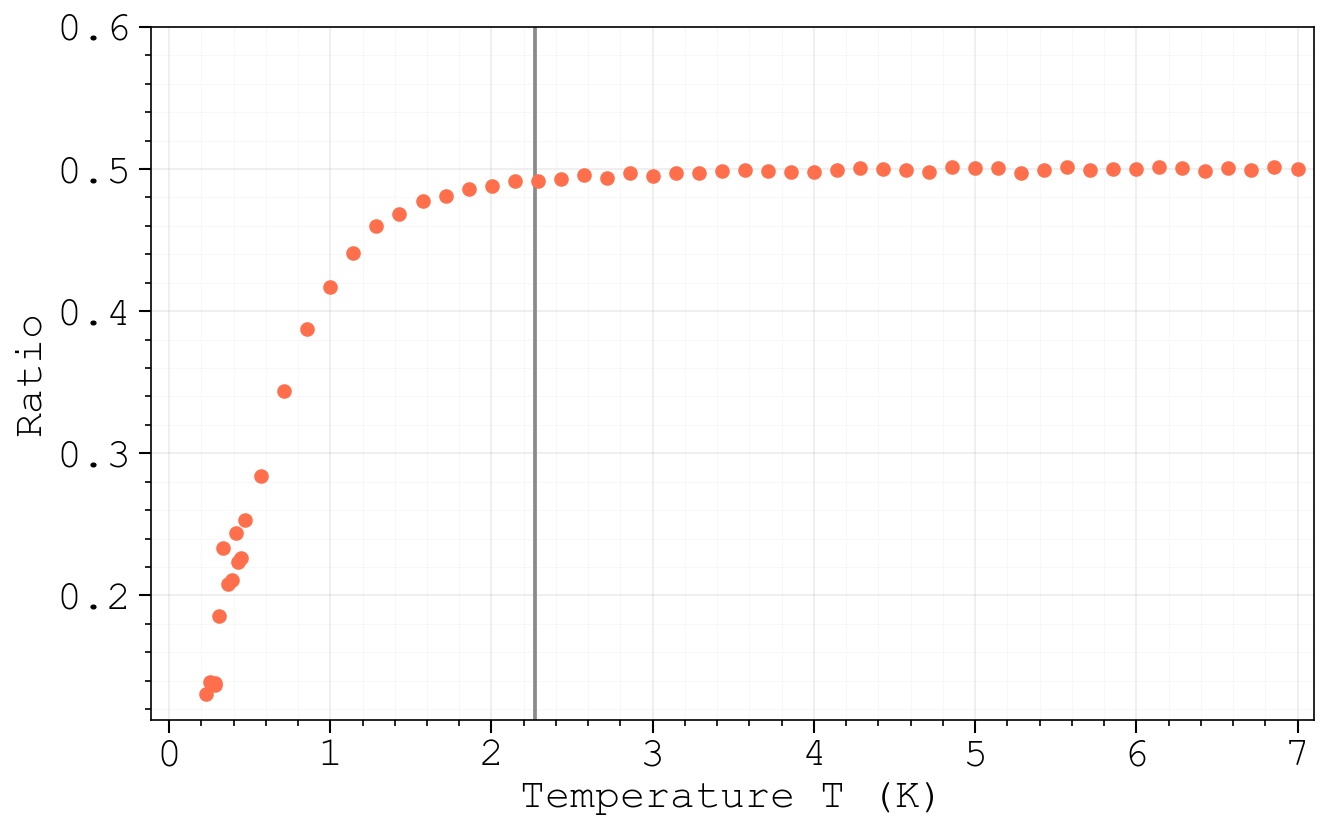

In [265]:
# Requires: `temperatures`, `results[0.0]['Ec']`, `results[0.5]['E1']`, `results[0.5]['E2']`

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# --- Fonts (same as before) ---
plt.rcParams.update({
    'font.family': ['Courier New', 'DejaVu Sans Mono', 'monospace'],
    'font.size': 20, 'axes.titlesize': 20, 'axes.labelsize': 20,
    'xtick.labelsize': 20, 'ytick.labelsize': 20, 'legend.fontsize': 20,
    'pdf.fonttype': 42, 'ps.fonttype': 42, 'savefig.dpi': 300, 'figure.dpi': 150,
})

# --- Grid & axes polish (like his) ---
def polish_axes(ax):
    ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
    ax.minorticks_on()
    ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
    ax.set_axisbelow(True)
    for s in ("bottom","left","top","right"):
        ax.spines[s].set_linewidth(0.8)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', direction='out', length=6, width=1.0)
    ax.tick_params(which='minor', length=3, width=0.8)

# --- Data (drop first two lowest-T points) ---
T  = np.asarray(temperatures, float)
idx = np.argsort(T)[2:]
T   = T[idx]
Ec  = np.asarray(results[0.0]['Ec'], float)[idx]
E1  = np.asarray(results[0.5]['E1'], float)[idx]
E2  = np.asarray(results[0.5]['E2'], float)[idx]

den = E2 - E1
mask = np.abs(den) > 1e-9
T_use = T[mask]
ratio = (Ec[mask] - E1[mask]) / den[mask]

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# points
ax.plot(T_use, ratio, linestyle='None', marker='o', markersize=6, color="#ff6f4b")

# vertical Onsager line (no label)
ONSAGER = 2.269185
ax.axvline(ONSAGER, color="#8a8a8a", linewidth=1.8, zorder=1)

# labels; no title
ax.set_xlabel("Temperature T (K)")
ax.set_ylabel("Ratio")

polish_axes(ax)

# ---- Set requested axis ranges ----
ax.set_xlim(right=7.1)  # keep current left, set max x to 7.1
ax.set_ylim(top=0.6)    # keep current bottom, set max y to 0.6

plt.show()
# fig.savefig("ratio_vs_T.png", dpi=300, bbox_inches="tight", pad_inches=0.01)
# fig.savefig("ratio_vs_T.svg", bbox_inches="tight")
# fig.savefig("ratio_vs_T.pdf", bbox_inches="tight")


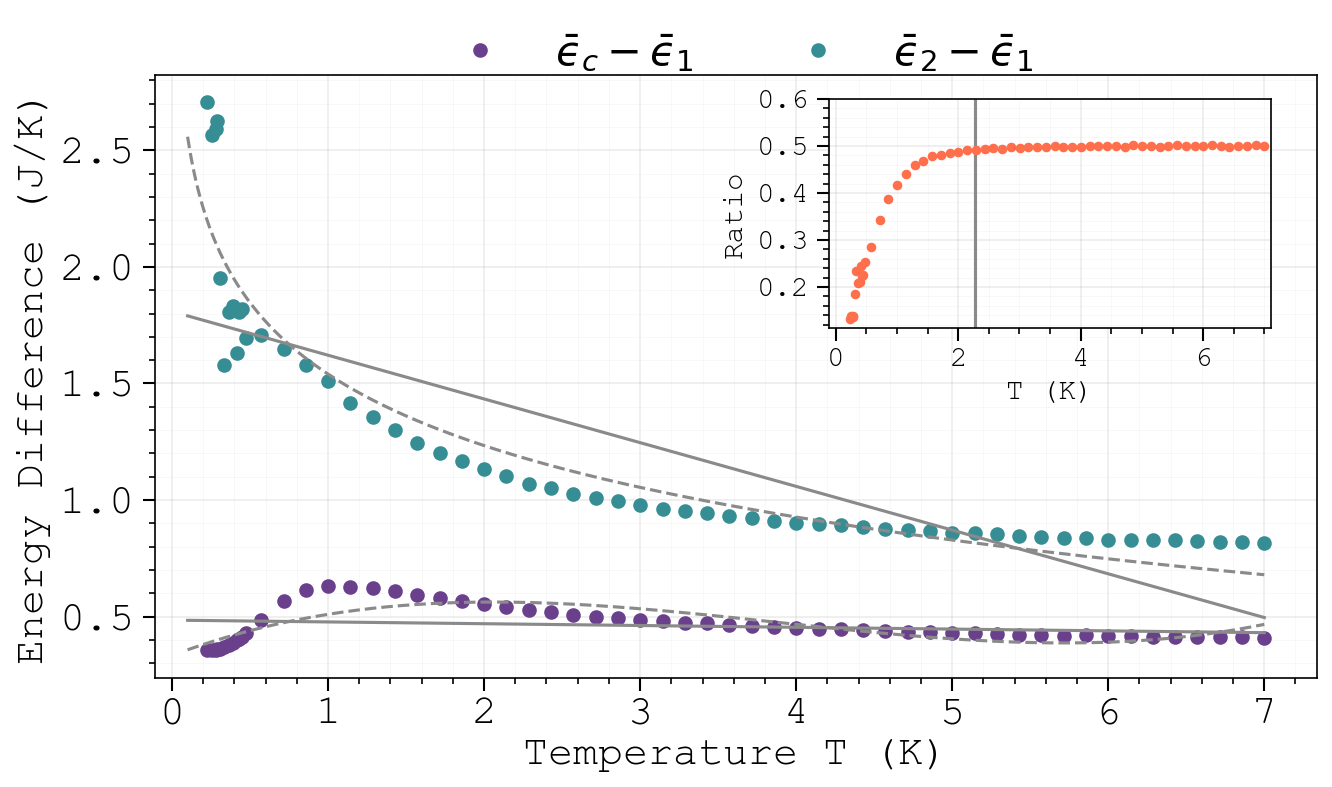

In [278]:
# ----- Second graph with ratio inset (top-right) -----
# Requires: `temperatures`, `results[0.0]['Ec']`, `results[0.5]['E1']`, `results[0.5]['E2']`
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes  # <-- for inset

plt.rcParams.update({
    'font.family': ['Courier New', 'DejaVu Sans Mono', 'monospace'],
    'font.size': 20, 'axes.labelsize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20,
    'legend.fontsize': 20, 'pdf.fonttype': 42, 'ps.fonttype': 42,
    'savefig.dpi': 300, 'figure.dpi': 150,
})

def polish_axes(ax):
    ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)
    ax.minorticks_on()
    ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
    ax.set_axisbelow(True)
    for s in ("bottom","left","top","right"):
        ax.spines[s].set_linewidth(0.8)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', direction='out', length=6, width=1.0)
    ax.tick_params(which='minor', length=3, width=0.8)

def smooth_poly(x, y, deg=2, n=400):
    x = np.asarray(x); y = np.asarray(y)
    order = np.argsort(x)
    x, y = x[order], y[order]
    deg = min(deg, max(1, len(x) - 1))
    coef = np.polyfit(x, y, deg)
    p = np.poly1d(coef)
    xs = np.linspace(x.min(), x.max(), n)
    ys = p(xs)
    return xs, ys

def log_fit_eval(x_fit, y_fit, xs=None, eps=None):
    x_fit = np.asarray(x_fit, float); y_fit = np.asarray(y_fit, float)
    if eps is None:
        eps = 0.0 if np.min(x_fit) > 0 else (-np.min(x_fit) + 1e-9)
    X = np.log(x_fit + eps)
    a1, a0 = np.polyfit(X, y_fit, 1)   # slope, intercept
    if xs is None:
        xs = np.linspace(np.min(x_fit), np.max(x_fit), 400)
    yhat = a0 + a1 * np.log(xs + eps)
    return xs, yhat, eps

# --------- Slice from 3rd point (by T) ---------
T = np.asarray(temperatures, float)
order = np.argsort(T)
keep_idx = order[2:]

T_plot = T[keep_idx]
E1 = np.asarray(results[0.5]['E1'], float)[keep_idx]
E2 = np.asarray(results[0.5]['E2'], float)[keep_idx]
Ec = np.asarray(results[0.0]['Ec'], float)[keep_idx]

diff_E2_E1 = E2 - E1
diff_Ec_E1 = Ec - E1

# --------- Colours ---------
col_e2e1 = "#378d94"  # teal   (E2−E1)
col_ece1 = "#6a408d"  # purple (Ec−E1)
reg_color = "#8a8a8a"
lw_line   = 1.5

# --------- MAIN PLOT ---------
fig, ax = plt.subplots(figsize=(10, 6))

# raw points
ax.plot(T_plot, diff_Ec_E1, 'o', ms=6, color=col_ece1, label=r'$\bar{ϵ}_c - \bar{ϵ}_1$')
ax.plot(T_plot, diff_E2_E1, 'o', ms=6, color=col_e2e1, label=r'$\bar{ϵ}_2 - \bar{ϵ}_1$')

ax.set_xlabel("Temperature T (K)")
ax.set_ylabel("Energy Difference (J/K)")
polish_axes(ax)

# ---- lock axes (fits won't change range)
xlim0, ylim0 = ax.get_xlim(), ax.get_ylim()

# ---- Draw all fitted lines from T = 0.1 to T = 7.0 ----
xs_draw = np.linspace(0.1, 7.0, 600)

# LR (solid grey)
m, b = np.polyfit(T_plot, diff_E2_E1, 1); ax.plot(xs_draw, m*xs_draw + b, color=reg_color, lw=lw_line)
m, b = np.polyfit(T_plot, diff_Ec_E1, 1); ax.plot(xs_draw, m*xs_draw + b, color=reg_color, lw=lw_line)

# PR (dashed): log for E2−E1, poly for Ec−E1
xs_ln, y_ln, _ = log_fit_eval(T_plot, diff_E2_E1, xs=xs_draw, eps=1e-9)
ax.plot(xs_ln, y_ln, color=reg_color, lw=lw_line, ls='--')
coef_pr = np.polyfit(T_plot, diff_Ec_E1, 3)
y_pr = np.poly1d(coef_pr)(xs_draw)
ax.plot(xs_draw, y_pr, color=reg_color, lw=lw_line, ls='--')

# restore axes
ax.set_xlim(xlim0); ax.set_ylim(ylim0)

# legend (only series)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1),
          ncol=2, frameon=False, borderaxespad=0.0)

# --------- INSET: Ratio plot (top-right) ---------
in_ax = ax.inset_axes([0.58, 0.58, 0.38, 0.38])  # [left, bottom, width, height] in axes fraction

# ratio data
den = (E2 - E1)
mask = np.abs(den) > 1e-9
T_use = T_plot[mask]
ratio = (Ec[mask] - E1[mask]) / den[mask]

# scatter points (thinner/smaller to fit inset)
in_ax.plot(T_use, ratio, linestyle='None', marker='o', ms=4, markeredgewidth=0.6, color="#ff6f4b")

# vertical Onsager line (no label)
ONSAGER = 2.269185
in_ax.axvline(ONSAGER, color=reg_color, linewidth=1.5, zorder=1)

# labels (smaller), grid like his
in_ax.set_xlabel("T (K)", fontsize=14)
in_ax.set_ylabel("Ratio", fontsize=14)
in_ax.tick_params(labelsize=14)
polish_axes(in_ax)

# enforce requested inset limits: x right=7.1, y top=0.6 (keep current left/bottom)
in_ax.set_xlim(right=7.1)

# keep top at 0.6; extend bottom if needed so 0.5 is inside the range
ymin, ymax = in_ax.get_ylim()
if ymin > 0.5:
    ymin = 0.0  # or set to whatever lower bound you prefer
in_ax.set_ylim(ymin, 0.6)

# force major ticks every 0.1 so 0.5 is a tick
in_ax.yaxis.set_major_locator(MultipleLocator(0.1))

plt.subplots_adjust(top=0.78)
plt.show()

# Save
fig.savefig("energy_differences_with_ratio_inset.png", dpi=300, bbox_inches="tight", pad_inches=0.03)
# fig.savefig("energy_differences_with_ratio_inset.svg", bbox_inches="tight")
# fig.savefig("energy_differences_with_ratio_inset.pdf", bbox_inches="tight")
